Monte Carlo Simulations. This Jupyter notebook contains the necessary Julia code to reproduce the simulation results in the paper "Functional Partial Least-Squares: Adaptive Estimation and Inference" by Andrii Babii, Marine Carrasco, and Idriss Tsafack. 

The code was tested on Julia v1.11.1.

In [1]:
# Define Functions
using LinearAlgebra, Random, Distributions, Plots, StatsPlots, BSplineKit, StatsBase, LaTeXStrings

function natural_spline_basis(s, d)
    B_basis = RecombinedBSplineBasis(BSplineBasis(2*d, s), Natural())
    T = length(s)
    B = zeros(T, T)
    dB = zeros(T, T)
    @views for j in 1:T
        B[:, j] = B_basis[j](s)
        dB[:, j] = B_basis[j](s, Derivative(d))
    end
    return B, dB
end

function spline(y, X, s, ρ_grid, d)
    n, T = size(X)

    # Compute natural cubic spline
    B, dB = natural_spline_basis(s, d)

    BtB_inv = inv(B' * B)
    P = B * BtB_inv * B'
    Dm = dB * dB'
    S = hcat([s .^ i for i in 0:(2*d - 1)]...)
    Am = S*inv(S'*S + 1e-50I)*S'/T + B * BtB_inv * Dm * BtB_inv * B' /T

    #βhat = P * inv(X' * X / (n * T) + ρ * Am) * X' * y / n
    βhat = zeros(T, length(ρ_grid))
    
    # Compute the estimator for each candidate ρ in the grid.
    for (i, ρ) in enumerate(ρ_grid)
        βhat[:, i] = P * inv(X' * X / (n * T) + ρ * Am) * (X' * y) / n
    end
    return βhat
end

function spline_gcv(y, X, s, ρ, d)
    n, T = size(X)

    # Compute natural cubic spline
    B, dB = natural_spline_basis(s, d)

    BtB_inv = inv(B' * B)
    P = B * BtB_inv * B'
    Dm = dB * dB'
    S = hcat([s .^ i for i in 0:(2*d - 1)]...)
    Am = S*inv(S'*S + 1e-50I)*S'/T + B * BtB_inv * Dm * BtB_inv * B' / T

    Hρ = X * P * inv(X' * X / (n * T^2) + ρ * Am / T) * X' / (n * T^2)

    GCV = sum((y - Hρ * y).^2) / n / (1 - tr(Hρ)/n)^2

    return GCV
end


function rkhs_gcv(y, X, λ_grid, s)
    n, T = size(X)
    beta_matrix = zeros(T, length(λ_grid))
    GCV = zeros(length(λ_grid))

    # Compute kernel matrix
    Δ = s .- transpose(s)
    B2_s = s.^2 .- s .+ 1/6
    B2_t = s.^2 .- s .+ 1/6
    B4_st = abs.(Δ).^4 - 2*abs.(Δ).^3 + abs.(Δ).^2 .- 1/30
    Km = (1/factorial(2)^2) * B2_s * B2_t' .- (1/factorial(4)) * B4_st

    # Compute Sigma and T matrix
    Σ = X * Km * X' / T^2
    T_matrix = zeros(n, 2)
    T_matrix[:, 1] = sum(X, dims=2) / T
    T_matrix[:, 2] = X * s / T
    
    for (j, λ) in enumerate(λ_grid)
        W = Σ + n * λ * I

        d = (T_matrix' * (W \ T_matrix)) \ (T_matrix' * (W \ y))
        c = W \ (y - T_matrix * d)
        beta_vals = d[1] .+ d[2] .* s .+ (c' * X * Km / T)'

        # Compute the residual sum of squares.
        RSS = sum((y - X * beta_vals / T).^2)

        # Compute the GCV score.
        GCV[j] = (RSS / n) / (1 - (2 + tr(inv(W) * Σ)) / n)^2
        
        # Store the estimated β for this λ.
        beta_matrix[:, j] = beta_vals
    end
    j_opt = argmin(GCV)

    return beta_matrix[:, j_opt]
end

function pca(r, K, m)
    # Returns PCA estimator based on j=1,2,...,m components
    βhat = zeros(length(r), m)
    (evals, evecs) = eigen(Symmetric(K))
    for j in 1:m
        λhat = evals[(end-j+1):end]
        vhat = evecs[:, (end-j+1):end]
        βhat[:, j] = vhat * (vhat'*r ./ λhat)
    end
    return βhat
end

function pls(r, K, m)
    # The minimum residual algorithm from Hanke (1992)
    # Returns PLS estimator based on j=1,2,...,m components
    # Conjugate Gradient algorithm for Kb = r with self-adjoint K
    # Integrals are approximated with Riemann sum over the uniform grid
    #S = 20
    βhat = zeros(length(r), m+1); e = r; d = r;
    for j in 1:m
        Kd = K*d
        α1 = e'*K*e
        α = α1 / (Kd'*Kd)           # step size for the slope
        βhat[:, j+1] = βhat[:, j] .+ α*d  # update the slope
        e = e .- α*Kd                     # update the residual
        γ = e'*K*e  / α1                      # step size for the conjugate direction
        d = e .+ γ*d                     # update the conjugate vectorf
    end
    return βhat[:, 2:end]
end

function pca_gcv(r, K, m)
    # n: number of observations
    T = length(r)
    
    # Preallocate storage for PCA estimates, RSS, and GCV scores
    βhat = zeros(T, m)
    GCV = zeros(m)
    
    # Compute the eigen-decomposition of the symmetric matrix K
    (evals, evecs) = eigen(Symmetric(K))
    
    for j in 1:m
        # Select the j largest eigenvalues and corresponding eigenvectors
        λhat = evals[(end - j + 1):end]
        vhat = evecs[:, (end - j + 1):end]
        
        # Compute the PCA-based estimator using j components
        βhat[:, j] = vhat * (vhat' * r ./ λhat)
        RSS = sum((r - K * βhat[:, j]).^2)
        
        # Compute the GCV score for j components.
        # Using the formula: GCV(j) = (RSS(j)/n) / (1 - j/n)^2
        GCV[j] = (RSS / T) / (1 - j / T)^2
    end
    
    # Select the number of components that minimizes the GCV score
    m_opt = argmin(GCV)
    
    # Return the optimal PCA estimator, the optimal number of components, and the GCV scores
    return βhat[:, m_opt], m_opt
end

function pls_early_stop(βhat_pls, X, y, r, K, τ, δ, n, βhat_pca)
    T, m = size(βhat_pls)
    
    X_norm = mean(sum(X.^2, dims=2) / T)  
    σ2     = mean((y - X * βhat_pca / T).^2)
    
    # Compute the moment vector
    mom = sqrt.(sum((K * βhat_pls .- r).^2, dims=1)' / T)
        
    # Compute the threshold using the updated σ² value.
    threshold = τ * sqrt(2 * σ2 * X_norm / δ / n)
    
    # Find the first index where the moment is less than or equal to the threshold.
    mhat_index = findfirst(mom .<= threshold)
    mhat = mhat_index[1]
    
    return βhat_pls[:, mhat], mhat, mom, threshold
end

function apls_cv(y, X, K, r, m_max; k_folds=5, rng=Random.GLOBAL_RNG)
    n, T = size(X)
    βhat_mat = zeros(T, m_max)
    CV_errors = zeros(m_max)
    
    # Indices for K-fold CV
    fold_indices = randperm(rng, n)
    fold_size = ceil(Int, n / k_folds)
    
    for m_val in 1:m_max
        fold_errors = zeros(k_folds)
        
        for k in 1:k_folds
            val_start = (k - 1) * fold_size + 1
            val_end = min(k * fold_size, n)
            val_idx = fold_indices[val_start:val_end]
            train_idx = setdiff(1:n, val_idx)
            
            # Split data
            y_tr, X_tr, = y[train_idx], X[train_idx, :]
            y_val, X_val = y[val_idx], X[val_idx, :]
            n_tr, T = size(X_tr)
            r_tr = X_tr' * y_tr / n_tr
            K_tr = X_tr' * X_tr / T / n_tr
            Kr_tr = r_tr             
            Zm_tr = X_tr * Kr_tr / T
            
            # Compute up to m_val components
            for j in 1:m_val
                α = inv(Zm_tr' * Zm_tr + 1e-50I) * (Zm_tr' * y_tr)
                βhat_current = Kr_tr * α
                βhat_mat[:, j] = βhat_current
                
                if j < m_val
                    new_Kr_tr = K_tr * Kr_tr[:, j] / n_tr
                    Kr_tr = hcat(Kr_tr, new_Kr_tr)
                    new_Zm_tr = X_tr * new_Kr_tr / n_tr
                    Zm_tr = hcat(Zm_tr, new_Zm_tr)
                end
            end
            α = inv(Zm_tr' * Zm_tr + 1e-50I) * (Zm_tr' * y_tr)
            βhat_current = Kr_tr * α
            # Predict on validation set and compute squared error
            y_pred = X_val * βhat_current
            fold_errors[k] = sum((y_val - y_pred).^2)
        end
        
        # Average validation error for current m_val
        CV_errors[m_val] = mean(fold_errors)
    end
    
    # Choose m that minimizes CV error
    m_opt = argmin(CV_errors)
    
    # Refit on full data using optimal m
    Kr = r
    Zm = X * Kr / T
    for j in 1:m_opt
        α = (Zm' * Zm) \ (Zm' * y)
        βhat_current = Kr * α
        βhat_mat[:, j] = βhat_current
        
        if j < m_opt
            new_Kr = K * Kr[:, j] / T
            Kr = hcat(Kr, new_Kr)
            new_Zm = X * new_Kr / T
            Zm = hcat(Zm, new_Zm)
        end
    end
    
    return βhat_mat[:, m_opt], m_opt
end


function simulation_cv(λ, β, v, s, M, n, J, m, param_grid, λ_grid)
    # Returns MSPE and MSE with data-driven choice of tuning parameters
    T = length(s)
    βhat_pls = zeros(T, M)
    βhat_apls = zeros(T, M)
    βhat_spl = zeros(T, M)
    βhat_rkhs = zeros(T, M)
    βhat_pca = zeros(T, M)
    mspe_pls = zeros(M, 1)
    mspe_apls = zeros(M, 1)
    mspe_spl = zeros(M, 1)
    mspe_rkhs = zeros(M, 1)
    mspe_pca = zeros(M, 1)
    m_pls = zeros(M, 1)
    m_apls = zeros(M, 1)
    
    for k in 1:M
        ε = rand(Normal(), n)
        u = rand(Normal(), (n, J))
        X = sqrt.(λ)'.* u * v'
        y = X * β / T .+ ε
        r = X' * y / n
        K = X' * X / (n*T)

        βhat0, _ = pca_gcv(r, K, m)
        βhat_pca[:, k] = βhat0
        βhat_pls_m = pls(r, K, m)
        βhat_pls[:, k], m_pls[k] = pls_early_stop(βhat_pls_m, X, y, r, K, τ, δ, n, βhat0)
        βhat_apls[:, k], m_apls[k] = apls_cv(y, X, K, r, m)
        gcv_vals = [spline_gcv(y, X, s, ρ, d) for (ρ, d) in param_grid]  # evaluate GCV for each pair
        (best_gcv, best_idx) = findmin(gcv_vals)   # find minimum GCV and its index
        ρ_opt, d_opt = param_grid[best_idx]     # extract the corresponding (ρ, d) pair
        βhat_spl[:, k] = spline(y, X, s, ρ_opt, d_opt)
        βhat_rkhs[:, k] = rkhs_gcv(y, X, λ_grid, s)

        u_test = rand(Normal(), (n, J))
        X_test = sqrt.(λ)'.* u_test * v'
        y_test = X_test * β / T .+ rand(Normal(), n)
        
        mspe_pls[k] = mean((y_test .- X_test * βhat_pls[:, k] / T).^2)
        mspe_apls[k] = mean((y_test .- X_test * βhat_apls[:, k] / T).^2)
        mspe_spl[k] = mean((y_test .- X_test * βhat_spl[:, k] / T).^2)
        mspe_pca[k] = mean((y_test .- X_test * βhat_pca[:, k] / T).^2)
        mspe_rkhs[k] = mean((y_test .- X_test * βhat_rkhs[:, k] / T).^2)
    end
    mse_pls = sum((βhat_pls .- β).^2, dims=1)' / T
    mse_apls = sum((βhat_apls .- β).^2, dims=1)' / T
    mse_spl = sum((βhat_spl .- β).^2, dims=1)' / T
    mse_pca = sum((βhat_pca .- β).^2, dims=1)' / T
    mse_rkhs = sum((βhat_rkhs .- β).^2, dims=1)' / T
    mspe_all = [mspe_pls'; mspe_apls'; mspe_spl'; mspe_pca'; mspe_rkhs']
    mse_all  = [mse_pls'; mse_apls'; mse_spl'; mse_pca'; mse_rkhs']
    return mspe_all, mse_all, m_pls, m_apls
end

function simulation_inference(λ, β, v, M, n, J, T, m)
    # Returns MSPE and MSE of PCA and PLS for j=1,2,...,m components
    Tn_H0 = zeros(M)
    Tn_H1 = zeros(M)
    D = zeros(M, 1)
    for k in 1:M
        ε = rand(Normal(), n)
        u = rand(Normal(), (n, J))
        X = sqrt.(λ)'.* u * v'
        y = X * β / T .+ ε

        r = X' * y / n
        K = X' * X / T / n
        Tn_H0[k] = only(n*sum((K * (pls(r, K, m)[:, end] .- β)).^2, dims=1) / T)
        D[k] = only(λ'*rand(Normal(), J).^2)
    end
    return Tn_H0, D
end

function plot_results(mspe, mse, labels, title_suffix)
    p_mspe = boxplot([mspe[i, :] for i in 1:5], 
        xticks=(1:5, labels), 
        ylabel="MSPE", 
        legend=false, 
        outliers=false,
        tickfont=font(12),
        guidefont=font(12))

    p_mse = boxplot([mse[i, :] for i in 1:5], 
        xticks=(1:5, labels), 
        ylabel="ISE", 
        legend=false,
        outliers=false,
        tickfont=font(12),
        guidefont=font(12))

    return p_mspe, p_mse
end

function power_curve(β, λ)
    # Parameters
    δ_vals = -1:0.05:1
    Δ = s
 
    Tn_H0 = zeros(M)
    power100 = Float64[]
    power200 = Float64[]

    # Get critical value under H0 for n = 100
    n = 100
    for k in 1:M
        ε = randn(n)
        u = randn(n, J)
        X = sqrt.(λ)' .* u * v'
        y0 = X * β / T .+ ε
        r0 = X' * y0 / n
        K = X' * X / T / n
        Tn_H0[k] = only(n * sum((K * (pls(r0, K, m)[:, end] .- β)).^2) / T)
    end
    crit_val = quantile(filter(!isnan, Tn_H0), 0.95)

    # Compute power at each δ for n = 100
    for δ in δ_vals
        Tn_H1 = zeros(M)
        for k in 1:M
            ε = randn(n)
            u = randn(n, J)
            X = sqrt.(λ)' .* u * v'
            y1 = X * (β .+ δ * Δ) / T .+ ε
            r1 = X' * y1 / n
            K = X' * X / T / n
            Tn_H1[k] = only(n * sum((K * (pls(r1, K, m)[:, end] .- β)).^2) / T)
        end
        push!(power100, mean(Tn_H1 .> crit_val))
    end

    # Get critical value under H0 for n = 200
    n = 200
    for k in 1:M
        ε = randn(n)
        u = randn(n, J)
        X = sqrt.(λ)' .* u * v'
        y0 = X * β / T .+ ε
        r0 = X' * y0 / n
        K = X' * X / T / n
        Tn_H0[k] = only(n * sum((K * (pls(r0, K, m)[:, end] .- β)).^2) / T)
    end
    crit_val = quantile(filter(!isnan, Tn_H0), 0.95)

    # Compute power at each δ for n = 200
    for δ in δ_vals
        Tn_H1 = zeros(M)
        for k in 1:M
            ε = randn(n)
            u = randn(n, J)
            X = sqrt.(λ)' .* u * v'
            y1 = X * (β .+ δ * Δ) / T .+ ε
            r1 = X' * y1 / n
            K = X' * X / T / n
            Tn_H1[k] = only(n * sum((K * (pls(r1, K, m)[:, end] .- β)).^2) / T)
        end
        push!(power200, mean(Tn_H1 .> crit_val))
    end

    p = plot(δ_vals, power100, xlabel="Scale Factor, δ", ylabel="Empirical Rejection Probability", label="n=100", legend=:top, ylim=(0,1), lw=2, legendfontsize=11, tickfont=font(12), guidefont=font(12)); 
    plot!(δ_vals, power200, label="n=200", legend=:top, ylim=(0,1), lw=2, legendfontsize=11, tickfont=font(12), guidefont=font(12), linestyle=:dash); 
    hline!(p, [0.05], linestyle=:dot, label="Nominal 5%");
    return p
end

function confidence_band(β, λ, J_cs, n_grid)
    # Construct basis V and coefficient grid of dimension J_cs x P
    V = v[:, 1:J_cs] # Cosine basis
    b_vals = collect(range(0.2, 4.2, length=n_grid))

    # Generate all combinations of b1,...,b_J_cs from b_vals
    grid_ranges = ntuple(_ -> b_vals, J_cs)
    b_grid = collect(Iterators.product(grid_ranges...))
    P = length(b_grid)
    b_matrix = hcat(Tuple.(b_grid)...)  # J_cs x P

    # Evaluate test statistic Tn on the grid
    B = reduce(hcat, [collect(b) for b in b_grid])

    # Simulate distribution for critical value
    S = 50_000
    D = zeros(S)
    for k in 1:S
        D[k] = λ' * randn(J).^2
    end
    qa = quantile(D, 1 - 0.05)

    beta_lo_rep  = zeros(T, M)
    beta_hi_rep  = zeros(T, M)
    for rep in 1:M
        ε = randn(n)
        u = randn(n, size(v,2))
        X = sqrt.(λ)' .* u * v'
        y = X * β ./ T .+ ε
        r = X' * y ./ n
        K = X' * X ./ (T * n)

        # PLS and test statistic on grid
        βhat = pls(r, K, 10)                           # your existing PLS call
        Tn   = n .* sum((K * (βhat[:,end] .- V * B)).^2, dims=1) ./ T

        # select those inside the confidence set
        good     = findall(vec(Tn) .<= qa)
        coeffs   = B[:, good]
        curves   = [V * c for c in eachcol(coeffs)]
        βmat     = reduce(hcat, curves)

        # record this run’s envelope
        beta_lo_rep[:, rep] = vec(minimum(βmat, dims=2))
        beta_hi_rep[:, rep] = vec(maximum(βmat, dims=2))
    end

    # --- compute pointwise medians across reps ---
    median_lo = mapslices(median, beta_lo_rep; dims=2)[:]
    median_hi = mapslices(median, beta_hi_rep; dims=2)[:]

    # --- plot ---
    p = plot(s, median_lo; fillrange=median_hi, fillalpha=0.3, linecolor=:transparent, label="95% Confidence Set")
    plot!(s, β; lw=3, linestyle=:dash, color=:blue, label="True Slope β", legendfontsize = 11, tickfont=font(12), guidefont=font(12))
    return p
end

function simulation_early_stopping(λ, β, v, s, M, n, J, m)
    # Returns MSPE and MSE with data-driven choice of tuning parameters
    T = length(s)
    βhat_pls = zeros(T, M)
    mspe_pls = zeros(M)
    m_pls = zeros(M)
    mom = zeros(m, M)
    mspe_all_m = zeros(m, M)
    threshold = zeros(M)
    
    for k in 1:M
        ε = rand(Normal(), n)
        u = rand(Normal(), (n, J))
        X = sqrt.(λ)'.* u * v'
        y = X * β / T .+ ε
        r = X' * y / n
        K = X' * X / (n*T)

        βhat0, _ = pca_gcv(r, K, m)
        βhat_pls_m = pls(r, K, m)
        βhat_pls[:, k], m_pls[k], mom[:, k], threshold[k] = pls_early_stop(βhat_pls_m, X, y, r, K, τ, δ, n, βhat0)

        X_test = sqrt.(λ)'.* rand(Normal(), (n, J)) * v'
        y_test = X_test * β / T .+ rand(Normal(), n)
        
        mspe_pls[k] = mean((y_test .- X_test * βhat_pls[:, k] / T).^2)
        mspe_all_m[:, k] = mean((y_test .- X_test * βhat_pls_m / T).^2, dims=1)'
    end
    mse_pls = sum((βhat_pls .- β).^2, dims=1)' / T
    return mse_pls, mspe_pls, βhat_pls, m_pls, mom, threshold, mspe_all_m
end

function confidence_band(β, λ)
    J_cs = 5
    n_grid = 20
    # Construct basis V and coefficient grid of dimension J_cs x P
    V = v[:, 1:J_cs] # Cosine basis
    b_vals = collect(range(0, 4.5, length=n_grid))

    # Generate all combinations of b1,...,b_J_cs from b_vals
    grid_ranges = ntuple(_ -> b_vals, J_cs)
    b_grid = collect(Iterators.product(grid_ranges...))
    P = length(b_grid)
    b_matrix = hcat(Tuple.(b_grid)...)  # J_cs x P

    # Evaluate test statistic Tn on the grid
    B = reduce(hcat, [collect(b) for b in b_grid])

    # Simulate distribution for critical value
    S = 50_000
    D = zeros(S)
    for k in 1:S
        D[k] = λ' * randn(J).^2
    end
    qa = quantile(D, 1 - 0.05)

    beta_lo_rep  = zeros(T, M)
    beta_hi_rep  = zeros(T, M)
    for rep in 1:M
        ε = randn(n)
        u = randn(n, size(v,2))
        X = sqrt.(λ)' .* u * v'
        y = X * β ./ T .+ ε
        r = X' * y ./ n
        K = X' * X ./ (T * n)

        # PLS and test statistic on grid
        βhat = pls(r, K, 10)                           # your existing PLS call
        Tn   = n .* sum((K * (βhat[:,end] .- V * B)).^2, dims=1) ./ T

        # select those inside the confidence set
        good     = findall(vec(Tn) .<= qa)
        coeffs   = B[:, good]
        curves   = [V * c for c in eachcol(coeffs)]
        βmat     = reduce(hcat, curves)

        # record this run’s envelope
        beta_lo_rep[:, rep] = vec(minimum(βmat, dims=2))
        beta_hi_rep[:, rep] = vec(maximum(βmat, dims=2))
    end

    # --- compute pointwise medians across reps ---
    median_lo = mapslices(median, beta_lo_rep; dims=2)[:]
    median_hi = mapslices(median, beta_hi_rep; dims=2)[:]

    # --- plot ---
    p = plot(s, median_lo; fillrange=median_hi, fillalpha=0.3, fillcolor=:gray, linecolor=:transparent, label="95% confidence band")
    plot!(s, β; lw=3, color=:black, label="Population Slope β", legendfontsize = 11, tickfont=font(12), guidefont=font(12))
    return p
end

confidence_band (generic function with 2 methods)

In [ ]:
# Figure 1: Estimation and Prediction Accuracy.
Random.seed!(2025) # Setting the seed
M = 5000; n = 100; J = 100; T = 200; m=70;
j = range(1, J)
s = range(0, 1, length = T) 
τ = 1.01; δ = 0.1;
m_plot = 10
ρ_grid = 10 .^ range(-12, -1, length=10)
d_grid = 1:4
param_grid = [(ρ, d) for d in d_grid for ρ in ρ_grid]  # create a grid of (ρ, d) tuples
group_labels = ["PLS", "APLS", "Splines", "PCA", "RKHS"]

# Model 1
v = sqrt(2) * cos.(π * s .* j');
v[:, 1] = ones(T);
b1 = 4 ./ j.^2.7;
β1 = v * b1
λ1 = 2 ./ j.^1.1

mspe1, mse1, mpls1, mapls1 = simulation_cv(λ1, β1, v, s, M, n, J, m, param_grid, ρ_grid)
p1_mspe, p1_mse = plot_results(mspe1, mse1, group_labels, "Model 1")
fig1 = plot(p1_mse, p1_mspe, layout=(1,2), size=(1000,900), plot_title = "Model 1: Estimation and Prediction")
display(fig1)
savefig(p1_mspe, "model1_spe.pdf")
savefig(p1_mse, "model1_ise.pdf")

# Model 2
b2 = copy(b1)
b2[1:5] .= 4
β2 = v * b2;

mspe2, mse2, mpls2, mapls2 = simulation_cv(λ1, β2, v, s, M, n, J, m, param_grid, ρ_grid)
p2_mspe, p2_mse = plot_results(mspe2, mse2, group_labels, "Model 2")
fig2 = plot(p2_mse, p2_mspe, layout=(1,2), size=(1000,900), plot_title = "Model 2: Estimation and Prediction")
display(fig2)
savefig(p2_mspe, "model2_spe.pdf")
savefig(p2_mse, "model2_ise.pdf")

# Model 3
λ3 = copy(λ1)
λ3[1:5] .= 2

mspe3, mse3, mpls3, mapls3 = simulation_cv(λ3, β1, v, s, M, n, J, m, param_grid, ρ_grid)
p3_mspe, p3_mse = plot_results(mspe3, mse3, group_labels, "Model 3")
fig3 = plot(p3_mse, p3_mspe, layout=(1,2), size=(1000,900), plot_title = "Model 3: Estimation and Prediction")
display(fig3)
savefig(p3_mspe, "model3_spe.pdf")
savefig(p3_mse, "model3_ise.pdf")


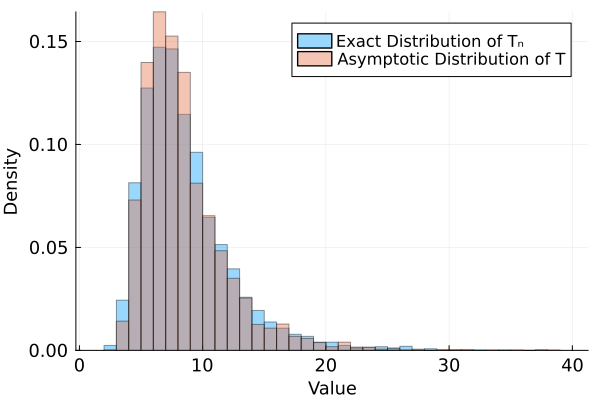

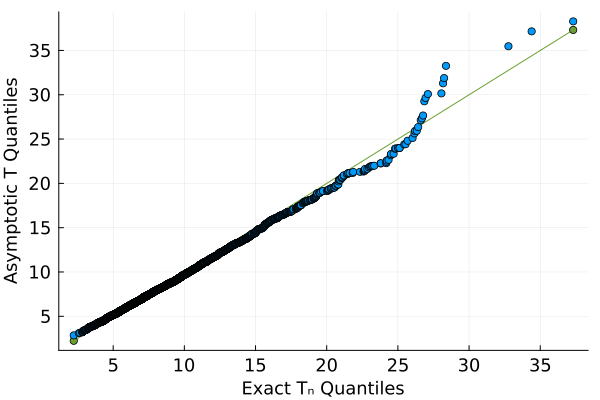

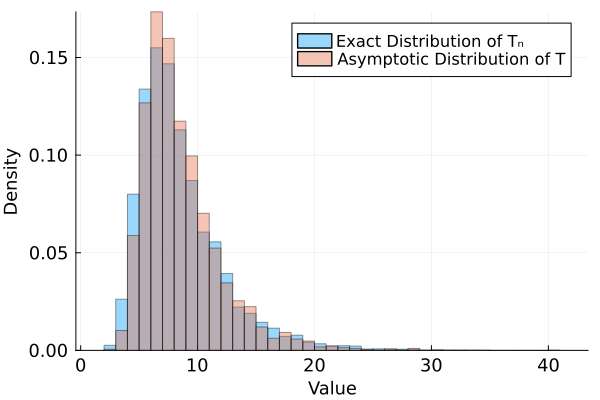

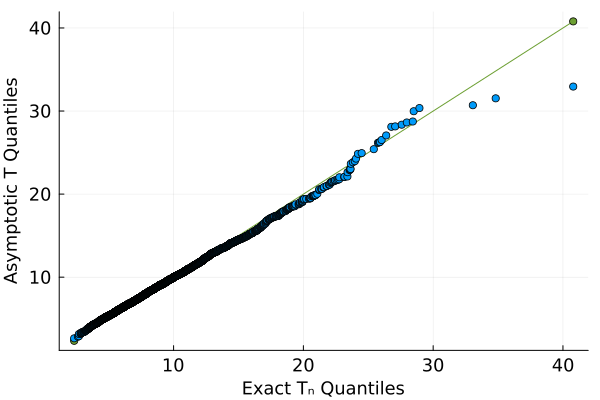

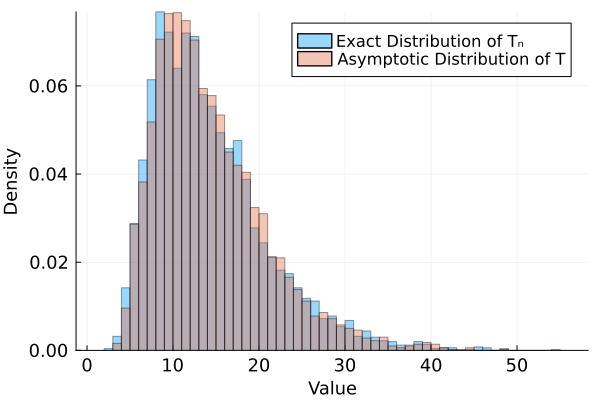

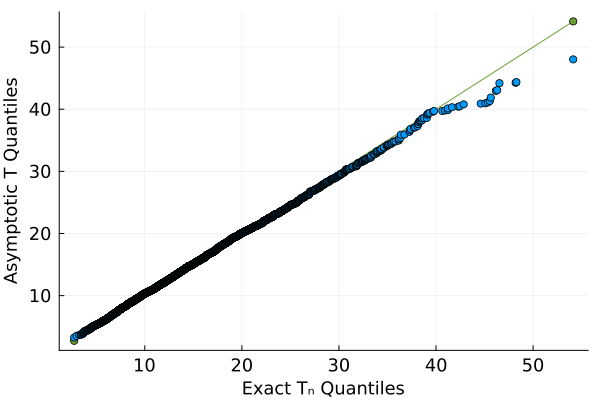

"/Users/ababii/Library/CloudStorage/Dropbox/Babii_Carrasco/jasa_R1/qqplot_model3.pdf"

In [ ]:
# Figure 2:Accuracy of Asymptotic Approximation

# Model 1
Tn1_H0, D1 = simulation_inference(λ1, β1, v, M, n, J, T, m)

# Histogram + Asymptotic overlay
p1 = histogram(Tn1_H0, bins=50, normalize=:pdf, alpha=0.4, label="Exact Distribution of Tₙ", xlabel="Value", ylabel="Density", tickfont=font(12), guidefont=font(12)); 
histogram!(p1, D1, bins=50, normalize=:pdf, alpha=0.4, label="Asymptotic Distribution of T", legendfontsize=11, tickfont=font(12), guidefont=font(12)); 
display(p1)
savefig(p1, "asymptotic_distribution1.pdf")

# QQ plot
qq1 = qqplot(Tn1_H0, D1[:,1], marker=:circle, label="", xlabel="Exact Tₙ Quantiles", ylabel="Asymptotic T Quantiles", tickfont=font(12), guidefont=font(12)); 
display(qq1)
savefig(qq1, "qqplot_model1.pdf")


# Model 2
Tn2_H0, D2 = simulation_inference(λ1, β2, v, M, n, J, T, m)

p2 = histogram(Tn2_H0, bins=50, normalize=:pdf, alpha=0.4, label="Exact Distribution of Tₙ", xlabel="Value", ylabel="Density", tickfont=font(12), guidefont=font(12)); 
histogram!(p2, D2, bins=50, normalize=:pdf, alpha=0.4, label="Asymptotic Distribution of T", legendfontsize=11, tickfont=font(12), guidefont=font(12)); 
display(p2)
savefig(p2, "asymptotic_distribution2.pdf")

qq2 = qqplot(Tn2_H0, D2[:,1], marker=:circle, label="", xlabel="Exact Tₙ Quantiles", ylabel="Asymptotic T Quantiles", tickfont=font(12), guidefont=font(12)); 
display(qq2)
savefig(qq2, "qqplot_model2.pdf")


# Model 3
Tn3_H0, D3 = simulation_inference(λ3, β1, v, M, n, J, T, m)

p3 = histogram(Tn3_H0, bins=50, normalize=:pdf, alpha=0.4, label="Exact Distribution of Tₙ", xlabel="Value", ylabel="Density", legendfontsize=11, tickfont=font(12), guidefont=font(12)); 
histogram!(p3, D3, bins=50, normalize=:pdf, alpha=0.4, label="Asymptotic Distribution of T", tickfont=font(12), guidefont=font(12));
display(p3)
savefig(p3, "asymptotic_distribution3.pdf")

qq3 = qqplot(Tn3_H0, D3[:,1], marker=:circle, label="", xlabel="Exact Tₙ Quantiles", ylabel="Asymptotic T Quantiles", tickfont=font(12), guidefont=font(12)); 
display(qq3)
savefig(qq3, "qqplot_model3.pdf")



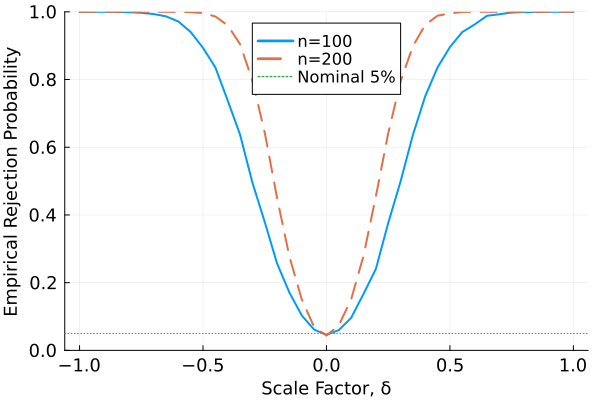

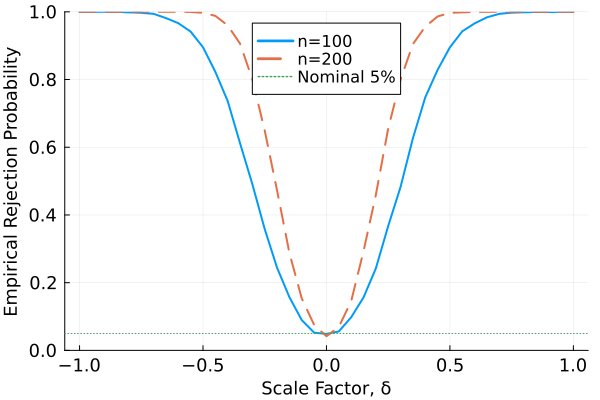

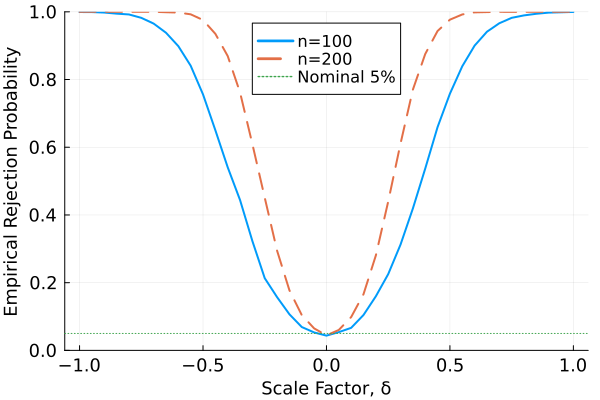

In [ ]:
# Figure 3: Power Curves

# Model 1
p1 = power_curve(β1, λ1)
savefig(p1, "power_curve_model1.pdf")
display(p1)

# Model 2
p2 = power_curve(β2, λ1)
savefig(p2, "power_curve_model2.pdf")
display(p2)

# Model 3
p3 = power_curve(β1, λ3)
savefig(p3, "power_curve_model3.pdf")
display(p3)


Median Number of Components is: m = 1.0

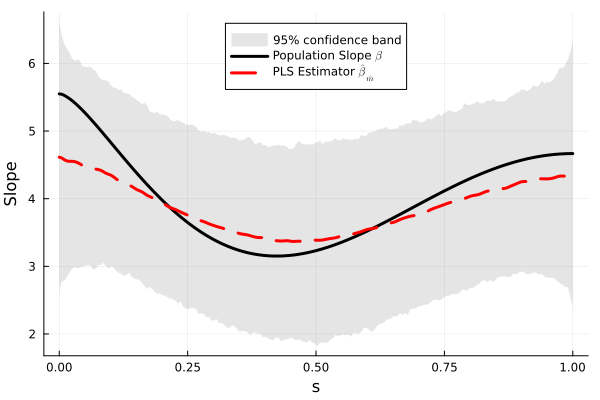

Median Number of Components is: m = 3.0


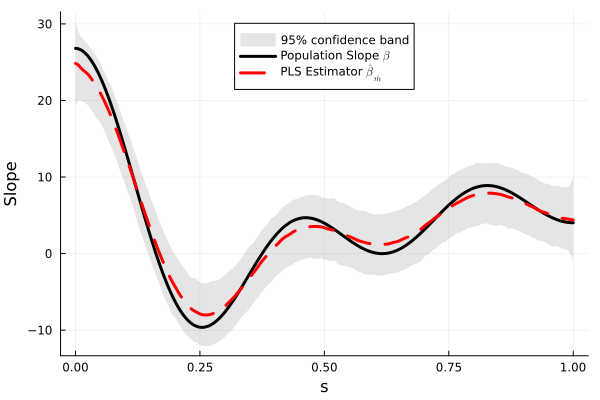

Median Number of Components is: m = 2.0


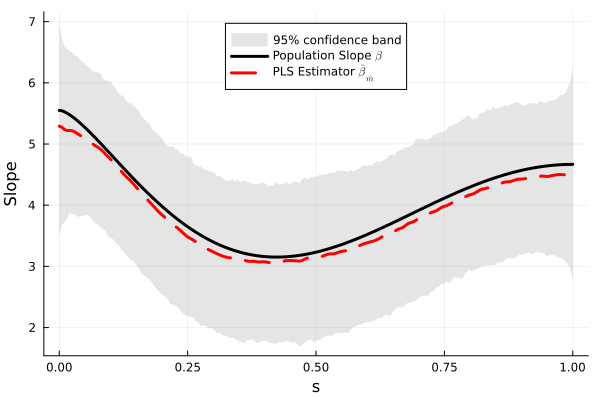

"/Users/ababii/Library/CloudStorage/Dropbox/Babii_Carrasco/jasa_R1/fig3_beta_mhat.pdf"

In [ ]:
# Figure S.1: Early Stopped PLS

# Model 1
mse_pls1, mspe_pls1, βhat_pls1, m_pls1, mom1, threshold1, mspe_all_m1 = simulation_early_stopping(λ1, β1, v, s, M, n, J, m)
β_pls1_mean = mean(βhat_pls1, dims = 2)
q05 = [quantile(row, 0.025) for row in eachrow(βhat_pls1)]
q95 = [quantile(row, 0.975) for row in eachrow(βhat_pls1)]
fig1_beta_mhat = plot(s, q05, fillrange=q95, linealpha=0, fillalpha=0.2, c=1, label = "95% confidence band", legend=:top, fillcolor = :gray)
plot!(s, [β1, β_pls1_mean], xlabel="s", ylabel="Slope", lw=3, label=[L"Population Slope $\beta$" L"PLS Estimator $\hat\beta_{\hat m}$"], linestyle=[:solid :dash], linecolor = [:black :red])
print(String("Median Number of Components is: m = $(median(m_pls1))"))
display(fig1_beta_mhat)
savefig(fig1_beta_mhat, "fig1_beta_mhat.pdf")

# Model 2
mse_pls2, mspe_pls2, βhat_pls2, m_pls2, mom2, threshold2, mspe_all_m2 = simulation_early_stopping(λ1, β2, v, s, M, n, J, m)
β_pls2_mean = mean(βhat_pls2, dims = 2)
q05 = [quantile(row, 0.025) for row in eachrow(βhat_pls2)]
q95 = [quantile(row, 0.975) for row in eachrow(βhat_pls2)]
fig2_beta_mhat = plot(s, q05, fillrange = q95, linealpha = 0, fillalpha = 0.2, label = "95% confidence band",
                      legend = :top, fillcolor = :gray)
plot!(s, [β2, β_pls2_mean], xlabel = "s", ylabel = "Slope", lw = 3,
      label = [L"Population Slope $\beta$" L"PLS Estimator $\hat\beta_{\hat m}$"],
      linestyle = [:solid :dash], linecolor = [:black :red])
println("Median Number of Components is: m = $(median(m_pls2))")
display(fig2_beta_mhat)
savefig(fig2_beta_mhat, "fig2_beta_mhat.pdf")

# Model 3
mse_pls3, mspe_pls3, βhat_pls3, m_pls3, mom3, threshold3, mspe_all_m3 = simulation_early_stopping(λ3, β1, v, s, M, n, J, m)
β_pls3_mean = mean(βhat_pls3, dims = 2)
q05 = [quantile(row, 0.025) for row in eachrow(βhat_pls3)]
q95 = [quantile(row, 0.975) for row in eachrow(βhat_pls3)]
fig3_beta_mhat = plot(s, q05, fillrange = q95, linealpha = 0, fillalpha = 0.2, label = "95% confidence band",
                      legend = :top, fillcolor = :gray)
plot!(s, [β1, β_pls3_mean], xlabel = "s", ylabel = "Slope", lw = 3,
      label = [L"Population Slope $\beta$" L"PLS Estimator $\hat\beta_{\hat m}$"],
      linestyle = [:solid :dash], linecolor = [:black :red])
println("Median Number of Components is: m = $(median(m_pls3))")
display(fig3_beta_mhat)
savefig(fig3_beta_mhat, "fig3_beta_mhat.pdf")



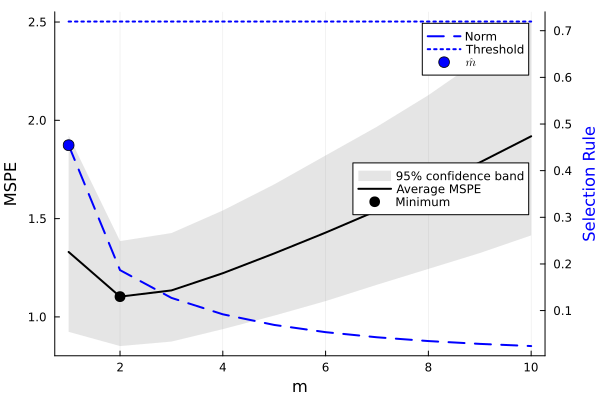

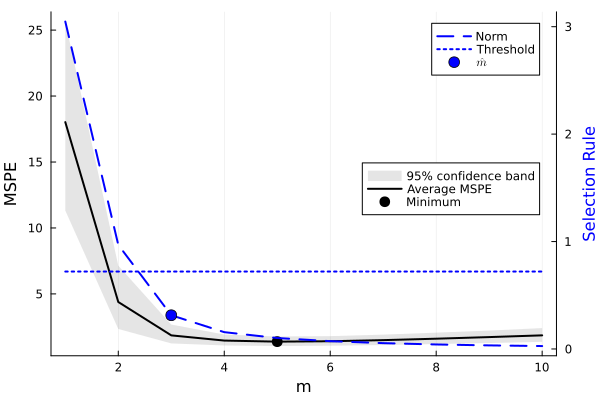

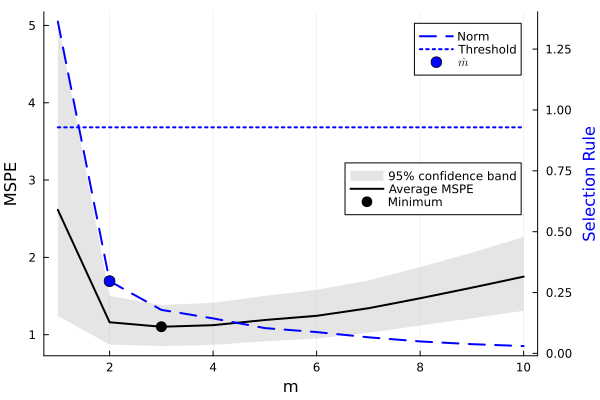

"/Users/ababii/Library/CloudStorage/Dropbox/Babii_Carrasco/jasa_R1/fig3_stop.pdf"

In [ ]:
# Figure S.2: Adaptive Early Stopping Visualization
mspe_all_m1 = mspe_all_m1[1:10, :]
mspe_pls1_mean = mean(mspe_all_m1, dims = 2)
m1_star = argmin(mspe_pls1_mean)[1]
q05 = [quantile(mspe_all_m1[j, :], 0.05) for j = 1:10]
q95 = [quantile(mspe_all_m1[j, :], 0.95) for j = 1:10]
fig1_stop = plot(1:10, q05, fillrange=q95, linealpha=0, fillalpha=0.2, c=1, label = "95% confidence band", legend=:right, fillcolor = :gray)
plot!(1:10, mspe_pls1_mean, xlabel="m", ylabel="MSPE", lw=2, label="Average MSPE", linecolor="black", legend=:right)
scatter!([m1_star], [mspe_pls1_mean[m1_star]], label="Minimum", markersize=6, markercolor=:black)
axis2 = twinx()
plot!(axis2, 1:10, [mean(mom1[1:10, :], dims=2), ones(10)*mean(threshold1)], ylabel="Selection Rule", lw=2, label=["Norm" "Threshold"], linestyle=[:dash :dot], linecolor = :blue, legend=:topright, yguidefontcolor=:blue)
scatter!(axis2, [median(m_pls1)], [mean(mom1[1:10, :], dims=2)[Int(median(m_pls1))]], label=L"$\hat m$", markercolor=:blue, markersize=6)
display(fig1_stop)
savefig(fig1_stop, "fig1_stop.pdf")

mspe_all_m2 = mspe_all_m2[1:10, :]
mspe_pls2_mean = mean(mspe_all_m2, dims = 2)
m2_star = argmin(mspe_pls2_mean)[1]
q05 = [quantile(mspe_all_m2[j, :], 0.05) for j = 1:10]
q95 = [quantile(mspe_all_m2[j, :], 0.95) for j = 1:10]
fig2_stop = plot(1:10, q05, fillrange=q95, linealpha=0, fillalpha=0.2, c=1, label = "95% confidence band", legend=:right, fillcolor = :gray)
plot!(1:10, mspe_pls2_mean, xlabel="m", ylabel="MSPE", lw=2, label="Average MSPE", linecolor="black", legend=:right)
scatter!([m2_star], [mspe_pls2_mean[m2_star]], label="Minimum", markersize=6, markercolor=:black)
axis2 = twinx()
plot!(axis2, 1:10, [mean(mom2[1:10, :], dims=2), ones(10) * mean(threshold2)], ylabel="Selection Rule", lw=2, label=["Norm" "Threshold"], linestyle=[:dash :dot], linecolor = :blue, legend=:topright, yguidefontcolor=:blue)
scatter!(axis2, [median(m_pls2)], [mean(mom2[1:10, :], dims=2)[Int(median(m_pls2))]], label=L"$\hat m$", markercolor=:blue, markersize=6)
display(fig2_stop)
savefig(fig2_stop, "fig2_stop.pdf")

# Model 3
mspe_all_m3 = mspe_all_m3[1:10, :]
mspe_pls3_mean = mean(mspe_all_m3, dims = 2)
m3_star = argmin(mspe_pls3_mean)[1]
q05 = [quantile(mspe_all_m3[j, :], 0.05) for j = 1:10]
q95 = [quantile(mspe_all_m3[j, :], 0.95) for j = 1:10]
fig3_stop = plot(1:10, q05, fillrange=q95, linealpha=0, fillalpha=0.2, c=1, label = "95% confidence band", legend=:right, fillcolor = :gray)
plot!(1:10, mspe_pls3_mean, xlabel="m", ylabel="MSPE", lw=2, label="Average MSPE", linecolor="black", legend=:right)
scatter!([m3_star], [mspe_pls3_mean[m3_star]], label="Minimum", markersize=6, markercolor=:black)
axis2 = twinx()
plot!(axis2, 1:10, [mean(mom3[1:10, :], dims=2), ones(10) * mean(threshold3)], ylabel="Selection Rule", lw=2, label=["Norm" "Threshold"], linestyle=[:dash :dot], linecolor = :blue, legend=:topright, yguidefontcolor=:blue)
scatter!(axis2, [median(m_pls3)], [mean(mom3[1:10, :], dims=2)[Int(median(m_pls3))]], label=L"$\hat m$", markercolor=:blue, markersize=6)
display(fig3_stop)
savefig(fig3_stop, "fig3_stop.pdf")



In [ ]:
# Figure S.3: Confidence Sets

# Model 1
confidence_band(β1, λ1)
savefig("cs_model1.pdf")
display(current())

# Model 2
confidence_band(β2, λ1)
savefig("cs_model2.pdf")
display(current())

# Model 3
confidence_band(β1, λ3)
savefig("cs_model3.pdf")
display(current())


